# Variant Frequency Analysis


1. Calculate number of variants that have MAF > 0.01 in
   1. GWAS credible sets
   2. all credible sets


In [ ]:
from collections.abc import Callable

import polars as pl
import seaborn as sns


In [2]:
# data generated by 01 and 02 notebooks
dataset = pl.read_parquet("../../data/rescaled-betas.parquet")
# NOTE! The dataset does not contain 1050 credible sets, that have missing nSamples - see notebook 02


In [26]:
class VariantFrequencyClass:
    def __init__(self, name, condition: Callable[[pl.Expr], pl.Expr]) -> None:
        self.name = name
        self.condition = condition

    def from_maf(self, maf: pl.Expr) -> pl.Expr:
        """Extract variant type from MAF."""
        condition = self.condition(maf)
        return pl.when(condition).then(True).otherwise(False).alias(self.name)


def variant_maf_classification(maf: pl.Expr, variant_types: list[VariantFrequencyClass] | None = None) -> pl.Expr:
    """Classify variants based on the maf thresholds."""
    if not variant_types:
        variant_types = [
            VariantFrequencyClass("common", lambda maf: (maf >= 0.01)),
            VariantFrequencyClass("rare", lambda maf: (maf < 0.01)),
        ]
    maf = pl.col("majorPopulationMAF")
    distributions = [vt.from_maf(maf) for vt in variant_types]
    return pl.struct(*distributions).alias("variantMAFClassification")


def variant_maf_inference_classification(maf: pl.Expr) -> pl.Expr:
    """Add a column to indicate if the MAF inference was correct. See notebook 01 for more details.

    This method is used to avoid filtering out variants that have:
    * MAF = 0.0 - majorAncestry AlleleFrequency was either 0.0 or not present in the GnomAD for the variant.
    * MAF = None - variant was not found at all in the GnomAD, thus no majorAncestry was reported.
    """
    return (
        pl.when(((maf == 0.0) | (maf.is_nan()) | (maf.is_null()) | (maf.is_infinite())))
        .then(False)
        .otherwise(True)
        .alias("correctMafInference")
    )


### Calculate class balance in all lead variants


In [27]:
df = (
    dataset.with_columns(variant_maf_inference_classification(pl.col("majorPopulationMAF")))
    .filter(pl.col("correctMafInference"))
    .select(
        pl.col("variantId"),
        variant_maf_classification(pl.col("majorPopulationMAF")),
    )
    .select(
        pl.col("variantId"),
        pl.col("variantMAFClassification").struct.unnest(),
    )
    .unpivot(
        on=["common", "rare"],
        index="variantId",
        variable_name="class",
        value_name="belongToClass",
    )
    .filter(pl.col("belongToClass"))
    .select("variantId", "class")
    .group_by("class")
    .agg(pl.len().alias("count"))
    .select(
        pl.col("class"),
        pl.col("count"),
        ((pl.col("count") / pl.col("count").sum()) * pl.lit(100)).round(2).alias("%"),
    )
    .sort("class")
    .with_columns(pl.lit("all").alias("modality"))
)
df


class,count,%,modality
str,u32,f64,str
"""common""",2494993,95.39,"""all"""
"""rare""",120613,4.61,"""all"""


### Calculate class balance in GWAS conly lead variants


In [28]:
df2 = (
    dataset.with_columns(variant_maf_inference_classification(pl.col("majorPopulationMAF")))
    .filter(pl.col("correctMafInference"))
    .filter(pl.col("studyType") == "gwas")
    .select(
        pl.col("variantId"),
        variant_maf_classification(pl.col("majorPopulationMAF")),
    )
    .select(
        pl.col("variantId"),
        pl.col("variantMAFClassification").struct.unnest(),
    )
    .unpivot(
        on=["common", "rare"],
        index="variantId",
        variable_name="class",
        value_name="belongToClass",
    )
    .filter(pl.col("belongToClass"))
    .select("variantId", "class")
    .group_by("class")
    .agg(pl.len().alias("count"))
    .select(
        pl.col("class"),
        pl.col("count"),
        ((pl.col("count") / pl.col("count").sum()) * pl.lit(100)).round(2).alias("%"),
    )
    .sort("class")
    .with_columns(pl.lit("gwas").alias("modality"))
)
df2


class,count,%,modality
str,u32,f64,str
"""common""",531712,92.97,"""gwas"""
"""rare""",40182,7.03,"""gwas"""


Text(0.5, 0, 'Lead variant distribution across MAF')

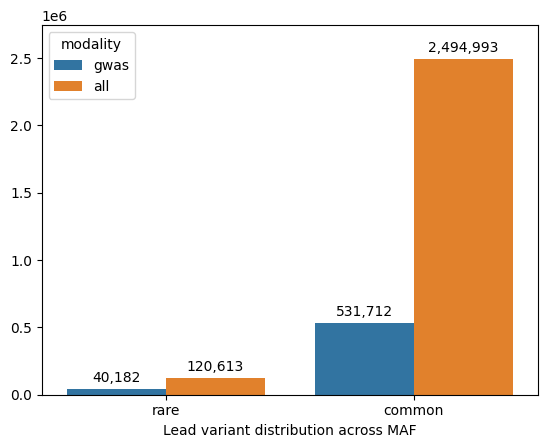

In [29]:
data = pl.concat([df, df2]).sort("count")
ax = sns.barplot(data=data, x="class", y="count", hue="modality")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{round(x):,}", padding=3)
ax.set_ylim(0, data["count"].max() * 1.1)
ax.set_ylabel("")
ax.set_xlabel("Lead variant distribution across MAF")
